In [ ]:
%matplotlib inline

import sys
sys.path.append('/home/ngr/gdrive/wearables/scripts')
import data as weardata

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import seaborn as sns

# eval
from sklearn.metrics import mean_absolute_error, roc_auc_score, accuracy_score


# model selection
from sklearn.model_selection import KFold

In [2]:
# get full actigraphy data to tease apart sequence lengths and label
data = weardata.load_pp_actigraphy()

In [6]:
df = pd.DataFrame()

In [23]:
df = pd.DataFrame()
for k, v in data.items():
    pid, GA, _ = k.split('-')
    dt = pd.DataFrame({'GA':int(GA), 'n_timepoints':len(v[0]), 'pid': pid}, index=[0])
    df = df.append(dt, ignore_index=True)
df = df.sort_values(by='GA')
df['n_h'] = df['n_timepoints'] / 60
df['n_d'] = df['n_h'] / 24

In [31]:
savefigs = True

No handles with labels found to put in legend.


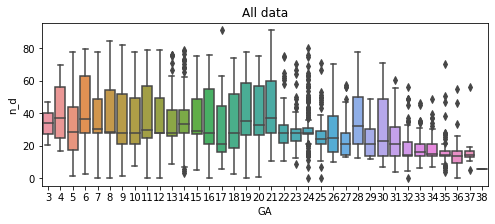

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

sns.boxplot(x='GA', y='n_d', data=df, ax=ax)
# sns.swarmplot(x='GA', y='n_timepoints', hue='pid', data=df, ax=ax, rasterized=True)

ax.set_title('All data')
# ax.legend().set_visible(False)
if savefigs:
    fig.savefig(os.path.join(os.getcwd(), '../results/boxplot_GAvsNtimepoints.png'), bbox_inches='tight', dpi=600)

In [2]:
# actually incorporate metadata
## per pid
md = pd.read_csv('/home/ngr/gdrive/wearables/data/MOD_1000_Woman_Activity_Data/MOD_Data_2021.csv', index_col=0)

/home/ngr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (16,22,36,77,97,117,137,195,215,235,255,275,315,335,426,440,462,463,465,466,485,506,536,577,581,625,626,627,668,671,673,674,697,700,701,703,704,705,708,709,712,713,730,798,799,804,807,808,812,817,818,822,880,881,885,886,890,891,908,1064,1067,1076,1084,1094,1095,1096,1097,1101,1102,1106,1132,1135,1136,1170,1250,1263,1577,1585,1586,1680,1739,1740,1741,1742,1743,1746,1747,1748,1749,1750,1870,1878,1879,1976,2166,2175,2188,2189,2203,2216,2217,2249,2250,2251,2252,2253,2256,2260,2261,2282,2283,2293,2294,2296,2297,2298,2299,2300,2303,2307,2308,2329,2340,2343,2344,2345,2346,2347,2350,2354,2355,2356,2376,2387,2390,2391,2392,2393,2394,2397,2401,2402,2423,2434,2437,2438,2439,2440,2441,2444,2448,2449,2450,2470,2471,2481,2484,2485,2486,2487,2488,2491,2495,2496,2517,2528,2531,2532,2533,2534,2535,2538,2542,2543,2544,2564,2575,2578,2579,2580,2581,2582,2585,2589,2590,2611,2622,2625,2626,2627,2628,26

In [27]:
def pad_align_transform_yID(data):
    '''Treat y as identifier to map with dictionary version of metadata outcomes
    
    '''
    X = np.empty((len(data.keys()), 24*60))
    y = pd.DataFrame(columns=['pid', 'GA'], index=list(range(len(data.keys()))))
    for i, (k, v) in enumerate(data.items()):
        ts, act = v[0], v[1]
        first_hour, first_min = ts[0].hour, ts[0].minute
        zeros2pad = np.zeros((first_hour*60 + first_min + 1))
        act = np.concatenate((zeros2pad, [float(i) for i in act[:24*60 - zeros2pad.shape[0]]]))
        if act.shape[0] < 24*60:
            act = np.concatenate((act, np.zeros((24*60-act.shape[0], ))))

        # add log-pseudocount
        act = np.log(act + 1)
        X[i, :] = act
        y.loc[i, 'pid'], y.loc[i, 'GA'] = k.split('-')[0], int(k.split('-')[1])
    return X, y


In [28]:
# data = weardata.load_pp_actigraphy()
# data_train, data_test = weardata.split_pp_actigraphy(data)
X_train, y_train = pad_align_transform_yID(data_train)
X_test, y_test = pad_align_transform_yID(data_test)

In [29]:
mdt = md.reset_index()
mdt['record_id'] = mdt['record_id'].astype(str)

In [30]:
y_train.merge(md.reset_index(), left_on='pid', right_on='record_id')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [ ]:
def sklearn_classifier(X_train_df, y_train, X_test_df, y_test, sk_modelclass, 
                      exp = 'RF_labs_ab', kfolds=5, 
                      verbose=True):
    '''Run sktime models on GA data
    
    TODO (ngr):
      1. add out_file storage in addition (or instead of) printing results
    '''
    if verbose:
        tic = time.time()
        print('Starting {} experiment...'.format(exp))
    models = {} # (tuple): (model, eval_criterion) where eval_criterion = MAE here

    kf = KFold(n_splits=kfolds, shuffle=True)
    for i, (train_idx, val_idx) in enumerate(kf.split(np.arange(X_train_df.shape[0]))):
        if verbose:
            sub_tic = time.time()
        X_train_df_cv, y_train_cv = X_train_df.iloc[train_idx, :], y_train[train_idx]
        X_val_df, y_val = X_train_df.iloc[val_idx, :], y_train[val_idx]

        # init model
        model = sk_modelclass # ComposableTimeSeriesForestRegressor()

        # fit, eval, store
        model.fit(X_train_df_cv, y_train_cv)
        acc = accuracy_score(y_train_cv, model.predict(X_val_df))
#         mae = mean_absolute_error(y_val, model.predict(X_val_df))
        models['CV{}'.format(i)] = (model, acc)
        del model
        
        if verbose:
            print('  k={}-fold finished in {:.1f}-s\ttotal_time_elapsed: {:.1f}-min'.format(i, time.time()-sub_tic, (time.time()-tic)/60))

    # store in file
    print('\n... finished in {:.1f}-min'.format((time.time()-tic)/60))
    print('\n----')
    print('{} results:'.format(exp))
    print('  <acc>_{}folds: {:.4f}\tSD_{}folds: {:.1f}'.format(kfolds, np.mean([v[1] for k,v in models.items()]), kfolds, np.std([v[1] for k,v in models.items()])))
    print('  acc_test: {:.4f}'.format(mean_absolute_error(y_test, models['CV{}'.format(np.argmax([v[1] for k,v in models.items()]))][0].predict(X_test_df))))
    print('----')
    
    return models